In [5]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from src.circuits.convolution.default import default_circuit

Step 0: Loss = 0.8676
Step 10: Loss = 0.8310
Step 20: Loss = 0.7261
Step 30: Loss = 0.5399
Step 40: Loss = 0.3395
Step 50: Loss = 0.1886
Step 60: Loss = 0.1031
Step 70: Loss = 0.0613
Step 80: Loss = 0.0406
Step 90: Loss = 0.0295


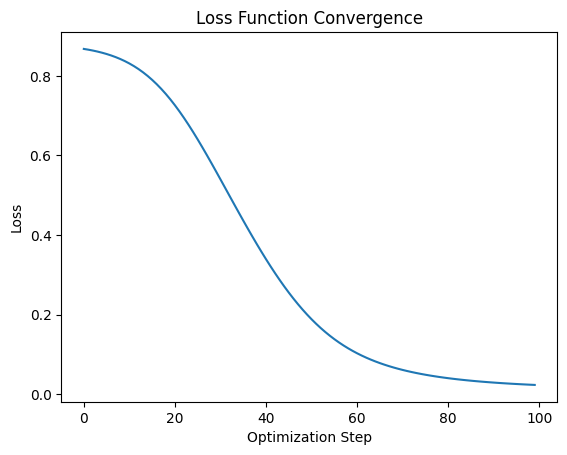

Training Accuracy: 100.00%


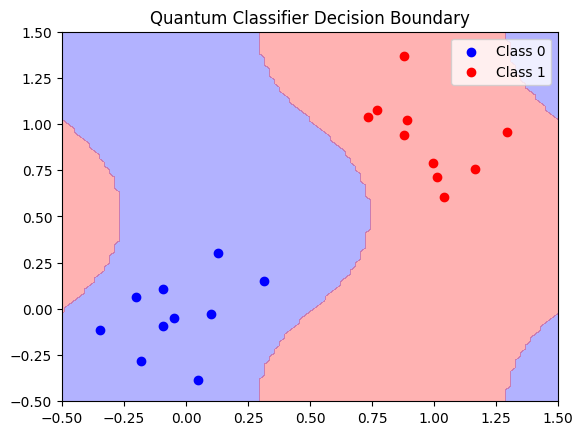

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# 1. Create a simple dataset
np.random.seed(42)
class0 = np.random.normal(0, 0.2, (10, 2))
class1 = np.random.normal(1, 0.2, (10, 2))
X = np.vstack((class0, class1))
Y = np.array([0]*10 + [1]*10)

# 2. Define the quantum circuit (Ansatz)
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='autograd')
def quantum_circuit(params, data):
    # Data Encoding
    for i in range(n_qubits):
        qml.RY(data[i] * np.pi, wires=i)
    
    # Variational Layers
    for layer in range(len(params)):
        for i in range(n_qubits):
            qml.RY(params[layer][i], wires=i)
            qml.RZ(params[layer][i], wires=i)
        qml.CNOT(wires=[0, 1])
    
    # Measurement (Hamiltonian)
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

# 3. Define the Hamiltonian (Loss Function)
def loss(params, X, Y):
    loss = 0
    for x, y in zip(X, Y):
        preds = quantum_circuit(params, x)
        prob = (np.array(preds) + 1) / 2  # Map from [-1,1] to [0,1]
        prediction = prob[0]  # Using the first qubit for simplicity
        loss += (prediction - y)**2
    return loss / len(X)

# 4. Initialize Parameters
n_layers = 2
np.random.seed(0)
initial_params = 0.01 * np.random.randn(n_layers, n_qubits)

# 5. Set up the Optimizer (Classical Part of VQE)
optimizer = qml.GradientDescentOptimizer(stepsize=0.1)
params = initial_params.copy()

# 6. Optimization Loop (VQE)
steps = 100
loss_history = []

for step_idx in range(steps):
    params, current_loss = optimizer.step_and_cost(lambda v: loss(v, X, Y), params)
    loss_history.append(current_loss)
    
    if step_idx % 10 == 0:
        print(f"Step {step_idx}: Loss = {current_loss:.4f}")

# 7. Plot Loss Convergence
plt.plot(loss_history)
plt.xlabel("Optimization Step")
plt.ylabel("Loss")
plt.title("Loss Function Convergence")
plt.show()

# 8. Make Predictions
def predict(params, x):
    preds = quantum_circuit(params, x)
    prob = (np.array(preds) + 1) / 2
    return 1 if prob[0] > 0.5 else 0

predictions = [predict(params, x) for x in X]
accuracy = np.mean(predictions == Y)
print(f"Training Accuracy: {accuracy * 100:.2f}%")

# 9. Visualize Decision Boundary
xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 100),
                     np.linspace(-0.5, 1.5, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
preds = np.array([predict(params, point) for point in grid])
preds = preds.reshape(xx.shape)

plt.contourf(xx, yy, preds, alpha=0.3, levels=[-0.1, 0.5, 1.1], colors=['blue', 'red'])
plt.scatter(class0[:,0], class0[:,1], color='blue', label='Class 0')
plt.scatter(class1[:,0], class1[:,1], color='red', label='Class 1')
plt.legend()
plt.title("Quantum Classifier Decision Boundary")
plt.show()


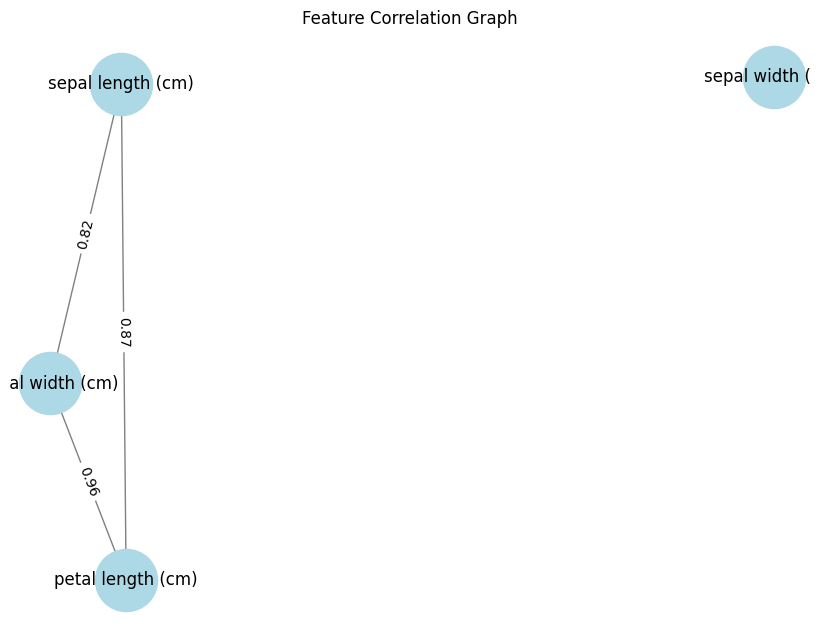

Tensor 0: shape (2, 2)
Tensor 1: shape (2, 2, 2)
Tensor 2: shape (2, 2, 2)
Tensor 3: shape (2, 2)


C:\Users\VPBV528\AppData\Roaming\Python\Python39\site-packages\pennylane\_grad.py:107: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Epoch 1: Loss = 0.9497


IndexError: list index out of range

In [2]:
import numpy as np
import networkx as nx
import tensorly as tl
from tensorly import tensor
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt

# 1. Load and preprocess the dataset
data = load_iris()
X = data['data']
y = data['target']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
correlation_matrix = np.corrcoef(X_scaled, rowvar=False)

# 2. Construct the feature correlation graph
threshold = 0.5
G = nx.Graph()
num_features = X_scaled.shape[1]
feature_names = data['feature_names']
G.add_nodes_from(feature_names)
for i in range(num_features):
    for j in range(i + 1, num_features):
        corr = correlation_matrix[i, j]
        if abs(corr) >= threshold:
            G.add_edge(feature_names[i], feature_names[j], weight=corr)

# Visualize the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
edges = G.edges(data=True)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Feature Correlation Graph")
plt.show()

# 3. Build the tensor network (MPS)
def build_mps_tensor_network(G, feature_names):
    sorted_features = sorted(feature_names)
    num_nodes = len(sorted_features)
    mps = []
    for i in range(num_nodes):
        if i == 0 or i == num_nodes - 1:
            tensor_shape = (2, 2)
        else:
            tensor_shape = (2, 2, 2)
        mps_tensor = tl.tensor(np.random.randn(*tensor_shape), dtype=tl.float32)
        mps.append(mps_tensor)
    return mps

mps = build_mps_tensor_network(G, feature_names)
for idx, t in enumerate(mps):
    print(f"Tensor {idx}: shape {t.shape}")

# 4. Define the quantum circuit
num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev, interface='autograd')
def quantum_circuit(inputs, mps_params):
    for i, feature in enumerate(feature_names):
        params = mps[i].reshape(-1)[:3]
        qml.RX(params[0] * inputs[i], wires=i % num_qubits)
        qml.RY(params[1] * inputs[i], wires=i % num_qubits)
        qml.RZ(params[2] * inputs[i], wires=i % num_qubits)
    for i in range(num_qubits):
        qml.RX(mps_params[i], wires=i)
        qml.RY(mps_params[i], wires=i)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0))

# 5. Define the cost function and training loop
def cost(params, mps_params, X, y):
    predictions = [quantum_circuit(x, mps_params) for x in X]
    probs = 1 / (1 + np.exp(-np.array(predictions)))
    labels = (y == 0).astype(int)
    loss = -np.mean(labels * np.log(probs + 1e-6) + (1 - labels) * np.log(1 - probs + 1e-6))
    return loss

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize parameters
mps_params = [mps[i].sum() for i in range(len(mps))]

# Optimize
optimizer = qml.GradientDescentOptimizer(stepsize=0.1)
num_epochs = 20

for epoch in range(num_epochs):
    loss = cost(None, mps_params, X_train, y_train)
    grads = qml.grad(cost)(None, mps_params, X_train, y_train)
    mps_params = [p - 0.1 * g for p, g in zip(mps_params, grads)]
    print(f"Epoch {epoch + 1}: Loss = {loss:.4f}")

# 6. Evaluation
def predict(mps_params, X):
    preds = [quantum_circuit(x, mps_params) for x in X]
    probs = 1 / (1 + np.exp(-np.array(preds)))
    return (probs > 0.5).astype(int)

y_pred = predict(mps_params, X_test)
y_true = (y_test == 0).astype(int)
accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


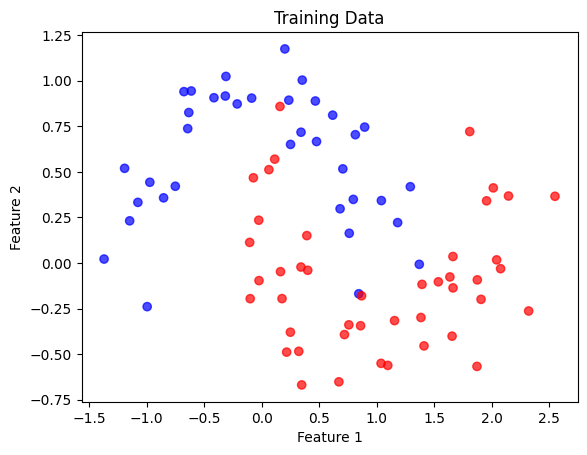

c:\Program Files\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


TypeError: 'int' object is not subscriptable

In [1]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1. Generate and Prepare the Dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional Visualization
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', alpha=0.7)
plt.title("Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# 2. Landmark Selection Using K-Means
m = 10  # Number of landmarks
kmeans = KMeans(n_clusters=m, random_state=42)
kmeans.fit(X_train)
landmarks = kmeans.cluster_centers_

# 3. Define the Quantum Feature Map
n_qubits = X_train.shape[1]
dev = qml.device("default.qubit", wires=n_qubits, shots=1024)

def quantum_feature_map(x, wires):
    """Quantum feature map using rotation and entangling gates."""
    for i in range(len(x)):
        qml.RY(x[i] * np.pi, wires=wires[i])
    # Entangling layers
    for i in range(n_qubits):
        qml.CNOT(wires=[wires[i], wires[(i + 1) % n_qubits]])

@qml.qnode(dev)
def prepare_state(x):
    """Quantum circuit to prepare the state from input data."""
    quantum_feature_map(x, wires=range(n_qubits))
    return qml.state()

# 4. Define the Quantum Circuit for Nystroem Approximation
# Number of qubits for landmarks encoding
n_landmark_qubits = n_qubits

# Define a quantum device with increased qubits to handle landmarks
total_qubits = n_qubits + m  # Additional qubits for landmarks
dev_nystroem = qml.device("default.qubit", wires=total_qubits, shots=1024)

def quantum_nystroem_circuit(x, landmarks, wires):
    """
    Quantum circuit implementing the Nystroem kernel approximation.
    - Encodes the input data point and landmarks.
    - Applies adjoint operations for kernel approximation.
    """
    # Encoding input data point on the first n_qubits
    quantum_feature_map(x, wires=wires[:n_qubits])
    
    # Encoding landmarks on the additional m qubits
    for idx, landmark in enumerate(landmarks):
        quantum_feature_map(landmark, wires=wires[n_qubits + idx])
    
    # Perform entanglement between data qubits and landmark qubits
    for i in range(n_qubits):
        for j in range(m):
            qml.CNOT(wires=[wires[i], wires[n_qubits + j]])
    
    # Apply adjoint operations: inverse feature map on data qubits
    for i in reversed(range(n_qubits)):
        qml.RY(-x[i] * np.pi, wires=wires[i])
    # Inverse entangling layers
    for i in reversed(range(n_qubits)):
        qml.CNOT(wires=[wires[(i + 1) % n_qubits], wires[i]])
    
    # Measurement: return expectation values for each landmark
    return [qml.expval(qml.PauliZ(wires=n_qubits + j)) for j in range(m)]

@qml.qnode(dev_nystroem)
def nystroem_kernel(x, landmarks):
    """
    Quantum circuit to compute the Nystroem kernel approximation.
    Returns expectation values corresponding to the kernel approximation.
    """
    return quantum_nystroem_circuit(x, landmarks, wires=range(total_qubits))

def compute_nystroem_kernel_matrix(X, landmarks):
    """
    Compute the approximate kernel matrix using the Quantum Nystroem method.
    """
    kernel_matrix = np.zeros((len(X), len(X)))
    for i, x in enumerate(X):
        expectation_values = nystroem_kernel(x, landmarks)
        # Aggregate expectation values to form the kernel
        # Here, we use the sum of expectation values as an example
        kernel_matrix[i] = np.sum(expectation_values)
    return kernel_matrix

# 5. Compute the Approximate Kernel Matrix for Training Data
approx_kernel_train = compute_nystroem_kernel_matrix(X_train, landmarks)

# 6. Train the SVM with Precomputed Kernel
svm = SVC(kernel='precomputed')
svm.fit(approx_kernel_train, y_train)

# 7. Compute the Approximate Kernel Matrix for Test Data
approx_kernel_test = compute_nystroem_kernel_matrix(X_test, landmarks)

# 8. Predict and Evaluate
y_pred = svm.predict(approx_kernel_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Training set size: (600, 2)
Testing set size: (400, 2)
Training Labels: [1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1
 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0
 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1
 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0
 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1
 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1
 1 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0
 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1
 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1
 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0
 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1
 0 0 1 1 1 0 1 0 1 0 0 0 1 1

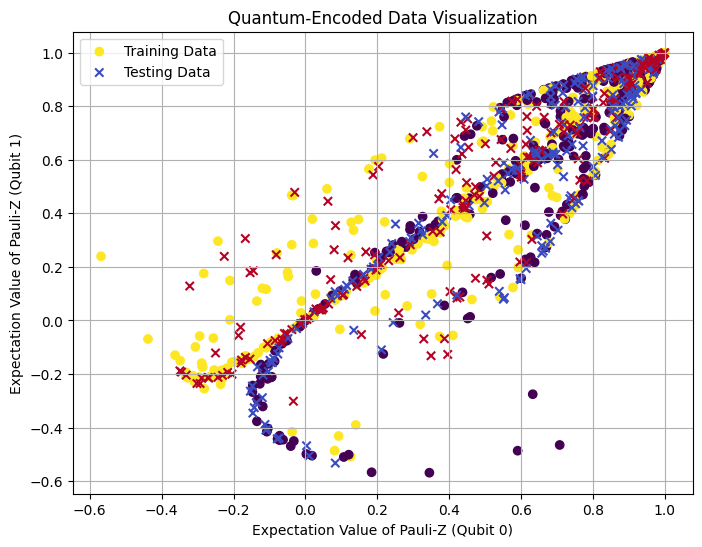

In [6]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Step 1: Prepare a larger dataset for demonstration
X, y = make_classification(
    n_samples=1000,      # Increased sample size
    n_features=2,      # Number of features per datapoint
    n_informative=2,
    n_redundant=0,
    random_state=42
)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Training Labels:", y_train)
print("Testing Labels:", y_test)

# Step 2: Define the quantum circuit for per-datapoint encoding
n_qubits = X_train.shape[1]  # 2 qubits

# Define the device
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='autograd')
def quantum_circuit_single(datapoint):
    # Initial Hadamard gates
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # Data Encoding using CRZ gates
    for i in range(n_qubits):
        control = i
        target = (i + 1) % n_qubits
        qml.CRZ(datapoint[i], wires=[control, target])
    
    # Additional Entanglement via CRZ gates with scaled angles
    for i in range(n_qubits):
        control = i
        target = (i + 1) % n_qubits
        qml.CRZ(datapoint[i] * 0.5, wires=[control, target])
    
    # Final Hadamard gates
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # Measurement: Expectation values of Pauli-Z on all qubits
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

def encode_individual_datapoints(X_data):
    features = []
    for datapoint in X_data:
        measurement = quantum_circuit_single(datapoint)
        features.append(measurement)
    return np.array(features)

# Step 3: Encode the training and testing data
X_train_quantum = encode_individual_datapoints(X_train)
X_test_quantum = encode_individual_datapoints(X_test)

print("Quantum Encoded Training Features Shape:", X_train_quantum.shape)
print("Quantum Encoded Testing Features Shape:", X_test_quantum.shape)
print("Quantum Encoded Training Features:", X_train_quantum)
print("Quantum Encoded Testing Features:", X_test_quantum)

# Step 4: Train the classical classifier
classifier = LogisticRegression()

classifier.fit(X_train_quantum, y_train)

y_pred = classifier.predict(X_test_quantum)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (Per-Datapoint Classification): {accuracy * 100:.2f}%")

# Step 5: Visualize the quantum features
plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_quantum[:, 0], X_train_quantum[:, 1],
    c=y_train, cmap='viridis', label='Training Data', marker='o'
)
plt.scatter(
    X_test_quantum[:, 0], X_test_quantum[:, 1],
    c=y_test, cmap='coolwarm', marker='x', label='Testing Data'
)
plt.xlabel('Expectation Value of Pauli-Z (Qubit 0)')
plt.ylabel('Expectation Value of Pauli-Z (Qubit 1)')
plt.title('Quantum-Encoded Data Visualization')
plt.legend()
plt.grid(True)
plt.show()


Training set size: (14, 3)
Testing set size: (6, 3)
Training Labels: [0 0 1 1 0 0 1 0 1 0 1 0 0 0]
Testing Labels: [1 0 1 1 1 1]
Test Accuracy: 0.00%


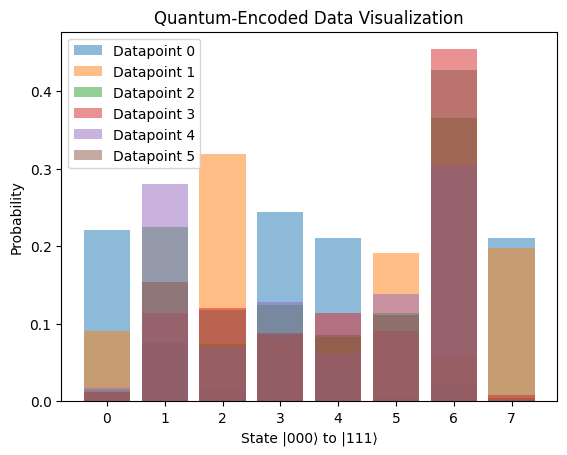

In [8]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Step 1: Prepare the dataset
X, y = make_classification(
    n_samples=20,      # Moderate sample size
    n_features=3,      # Number of features per datapoint
    n_informative=3,
    n_redundant=0,
    random_state=42
)

# Normalize the features
X = X / np.linalg.norm(X, axis=1, keepdims=True)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Training Labels:", y_train)
print("Testing Labels:", y_test)

# Step 2: Define Oracle and Diffusion Operators with 3 Qubits
def oracle():
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.Toffoli(wires=[0, 1, 2])  # Corrected to unique wires
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)

def diffusion():
    # Apply Hadamard gates to all qubits
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    
    # Apply PauliX gates to all qubits
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    
    # Apply Toffoli gate
    qml.Toffoli(wires=[0, 1, 2])
    
    # Apply PauliX gates again
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    
    # Apply Hadamard gates again
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)

# Step 3: Define the Quantum Circuit with QAA
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, interface='autograd')
def qaa_circuit(x):
    # Step 1: Initialize qubits in superposition
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    
    # Step 2: Feature map encoding (example using RY gates)
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)
    qml.RY(x[2], wires=2)
    
    # Step 3: Apply QAA iterations
    iterations = 1  # Adjust based on dataset size and desired amplification
    for _ in range(iterations):
        oracle()
        diffusion()
    
    # Step 4: Measurement
    return qml.probs(wires=[0, 1, 2])

# Step 4: Define the Classifier Using QAA Probabilities
def qaa_classifier(X):
    predictions = []
    for x in X:
        probs = qaa_circuit(x)
        pred = np.argmax(probs)
        predictions.append(pred)
    return np.array(predictions)

# Step 5: Make Predictions and Evaluate
y_pred = qaa_classifier(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Step 6: Visualize the Quantum Features (Optional)
# Note: With QAA, visualizing probabilities can provide insights
def visualize_probabilities(X, y, title="Quantum-Encoded Data Visualization"):
    probs = []
    for x in X:
        prob = qaa_circuit(x)
        probs.append(prob)
    probs = np.array(probs)
    
    # Plot the probability distributions
    for i, prob in enumerate(probs):
        plt.bar(range(len(prob)), prob, alpha=0.5, label=f'Datapoint {i}')
    
    plt.xlabel('State |000⟩ to |111⟩')
    plt.ylabel('Probability')
    plt.title(title)
    plt.legend()
    plt.show()

# Uncomment to visualize
visualize_probabilities(X_test, y_test)
